0 : Box(20,)
1 : Box(20,)
10 : Box(20,)
11 : Box(20,)
12 : Box(20,)
13 : Box(20,)
14 : Box(20,)
2 : Box(20,)
3 : Box(20,)
4 : Box(20,)
5 : Box(20,)
6 : Box(20,)
7 : Box(20,)
8 : Box(20,)
9 : Box(20,)
Eps  0 Reward 136.0
Eps  10 Reward 129.76823872447682
Eps  20 Reward 137.69357529099892
Eps  30 Reward 130.145106360269
Eps  40 Reward 118.26467243267841
Eps  50 Reward 112.0
Eps  60 Reward 156.0
Eps  70 Reward 145.04599081674374
Eps  80 Reward 140.0
Eps  90 Reward 127.66680236802581
Eps  100 Reward 128.0
Eps  110 Reward 132.9163248777559
Eps  120 Reward 164.0
Eps  130 Reward 130.19889924552632
Eps  140 Reward 140.0
Eps  150 Reward 129.0852146570373
Eps  160 Reward 120.19425257286164
Eps  170 Reward 120.0
Eps  180 Reward 158.35786598540872
Eps  190 Reward 130.27810225841884
Eps  200 Reward 144.4552572580556
Eps  210 Reward 152.0
Eps  220 Reward 146.62954734177524
Eps  230 Reward 112.2008472822062
Eps  240 Reward 119.9494370222437
Eps  250 Reward 161.65986965148664
Eps  260 Reward 142.68938

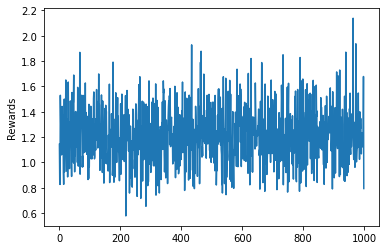

In [1]:

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from recsim.environments import interest_evolution
from recsim.environments import interest_exploration
from recsim.environments import long_term_satisfaction
from gym import spaces

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import pdb

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def weight_init(m):
    """Custom weight init for Conv2D and Linear layers."""
    if isinstance(m, nn.Linear):
        nn.init.orthogonal_(m.weight.data)
        if hasattr(m.bias, 'data'):
            m.bias.data.fill_(0.0)

class MLP(nn.Module):
    def __init__(self,
                 input_dim,
                 hidden_dim,
                 output_dim,
                 hidden_depth,
                 output_mod=None):
        super().__init__()
        self.trunk = mlp(input_dim, hidden_dim, output_dim, hidden_depth,
                         output_mod)
        self.apply(weight_init)

    def forward(self, x):
        return self.trunk(x)


def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), nn.ReLU(inplace=True)]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), nn.ReLU(inplace=True)]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk


#env = gym.make('CartPole-v0').unwrapped
env_config = {'slate_size': 2,
              'seed': 0,
              'num_candidates': 15,
              'resample_documents': True}

env = interest_evolution.create_environment(env_config)
#env = long_term_satisfaction.create_environment(env_config)
for key, space in env.observation_space['doc'].spaces.items():
  print(key, ':', space)

user_space = env.observation_space['user']
doc_space = env.observation_space['doc']
num_candidates = env_config['num_candidates']
doc_space_shape = spaces.flatdim(list(doc_space.spaces.values())[0])
# Use the longer of user_space and doc_space as the shape of each row.
obs_shape = (np.max([spaces.flatdim(user_space), doc_space_shape]),)[0]

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))
env.reset()

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

hidden_dim = 64
obs_dim = obs_shape + doc_space_shape * num_candidates + 5
hidden_depth = 2
#output_dim = spaces.MultiDiscrete(num_candidates * np.ones((env_config['slate_size'],)))
output_dim = env.action_space.nvec[0]

# TODO : Maybe add the action backinto obs
policy_net = MLP(obs_dim, hidden_dim, output_dim, hidden_depth)
target_net = MLP(obs_dim, hidden_dim, output_dim, hidden_depth)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(output_dim)]], device=device, dtype=torch.long)

def flatten_obs(obs):

    obs_usr = obs['user']
    obs_docs = obs['doc']
    response = obs['response']
    all_docs = []
    all_responses = []
    for _, item in obs_docs.items():
        all_docs.append(item)
    if response is not None:
        for _, item in response[0].items():
            all_responses.append(item)
    else:
        response_pad = np.zeros((5), dtype=np.float64)
        all_responses.append(response_pad)
    # TODO : This is ugly fix it.
    all_responses = np.array(all_responses).flatten()

    all_docs_np = np.array(all_docs).flatten()
    obs_flatten = np.concatenate((obs_usr, all_docs_np, all_responses), axis=0)
    return obs_flatten

episode_durations = []
all_losses = []

def optimize_model(i_episode):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1).float())

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    #pdb.set_trace()
    if i_episode % 500 == 0:
        print('Eps ', i_episode, 'Loss', loss.item())
        all_losses.append(loss.item())

num_episodes = 1000
all_rewards = []
eps_reward = 0.0

for i_episode in range(num_episodes):
    # Initialize the environment and state
    obs = env.reset()
    obs = flatten_obs(obs)
    for t in count():
        # Select and perform an action
        obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        action = select_action(obs_tensor)
        # TODO: step wants an array
        obs_next, reward, done, _ = env.step([action.item()])
        reward = torch.tensor([reward], device=device)
        obs_next = flatten_obs(obs_next)
        
        eps_reward += reward.item()
    
        #last_screen = current_screen
        #current_screen = get_screen()
        if done:
            obs_next = None
            if i_episode % 10 == 0:
                print('Eps ', i_episode, 'Reward', eps_reward)
        else:
            obs_next_tensor = torch.tensor(obs_next, dtype=torch.float32, device=device).unsqueeze(0)
        # Store the transition in memory
        memory.push(obs_tensor, action, obs_next_tensor, reward)

        # Move to the next state
        obs = obs_next
        # Perform one step of the optimization (on the policy network)
        optimize_model(i_episode)
        if done:
            episode_durations.append(t + 1)
            #print('Episode duration ', t)
            all_rewards.append(eps_reward/t)
            eps_reward = 0.0
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
plt.plot(all_rewards)
plt.ylabel('Rewards')
plt.show()


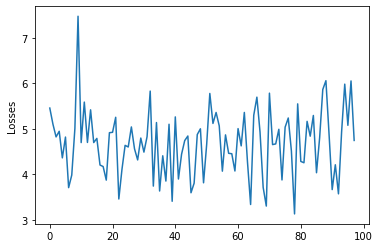

In [2]:
plt.clf()
plt.plot(all_losses)
plt.ylabel('Losses')
plt.show()